In [5]:

from matplotlib import pyplot as plt
import os
import numpy as np
import glob
import os

## astropy
import astropy.units as u
from astropy.table import Table

## calin
from cta.nectarcam.feb.I_NmcConfig import NmcConfig

## ctapipe
from ctapipe_io_nectarcam import NectarCAMEventSource 
from ctapipe.io import event_source, EventSeeker

import scipy.stats as scsp
from scipy.stats import poisson                                                                                                             


#import seaborn as sns


plt.rcParams['figure.figsize'] = [15, 7]

In [13]:
        #MC_file_path ='/media/ttaverni/Transcend/MC_s/Heide/nsb0_thrs0_new_notes.simtel.gz'
        #MC_file_path = '/media/ttaverni/Transcend/MC_s/Heide/nsb125_thrs0_new_notes.simtel.gz'
        #MC_file_path = '/media/ttaverni/Transcend/MC_s/Heide/nsb250_thrs0_new_notes.simtel.gz'
        #MC_file_path = '/media/ttaverni/Transcend/MC_s/Heide/nsb500_thrs0_new_notes.simtel.gz'
        MC_file_path = '/media/ttaverni/Transcend/MC_s/Heide/nsb500_thrs0_new_notes_large-stat.simtel.gz'
        
        inputfile_reader = event_source(
            input_url = MC_file_path,
            max_events=300)

        all_wfs = []
        for ii, event in enumerate(inputfile_reader):
            all_wfs.append(event.r0.tel[1].waveform[0])
        wfs_MC = np.array(all_wfs)

In [14]:
        ## NSB = 0 : 
        #data_file_path = '/media/ttaverni/Transcend/data/dataR1/NectarCAM.Run1533.000[0-9].fits.fz'
        ## NSB ~= 125 MHz (?) : 
        #data_file_path = '/media/ttaverni/Transcend/data/dataR1/NectarCAM.Run1538.000[0-9].fits.fz'
        ## NSB <~= 250 MHz (?) : 
        #data_file_path = '/media/ttaverni/Transcend/data/dataR1/NectarCAM.Run1539.000[0-9].fits.fz'
        ## NSB <= 500 MHz (?) : 
        data_file_path = '/media/ttaverni/Transcend/data/dataR1/NectarCAM.Run1542.000[0-9].fits.fz'

        
        inputfile_reader = NectarCAMEventSource(
            input_url = data_file_path,
            max_events=5000)

        cfg = inputfile_reader.camera_config
        pix_ids = cfg.expected_pixels_id
        
        all_wfs = []
        for ii, event in enumerate(inputfile_reader):
            all_wfs.append(event.r0.tel[event.r0.tels_with_data[0]].waveform[0,pix_ids])
            if ii > len(wfs_MC)-3 : 
                break
        wfs_data = np.array(all_wfs)

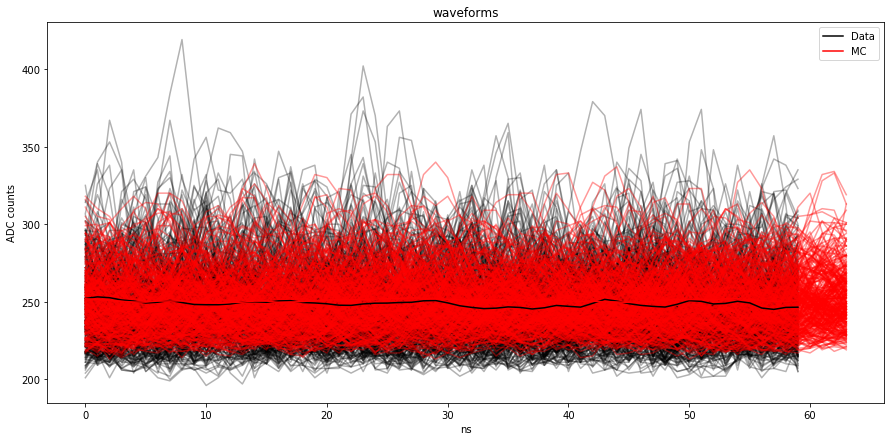

In [15]:
p = plt.plot(wfs_data[:,3,:].T,color='black',alpha=.3)
p = plt.plot(wfs_MC[:,0,:].T,color='red',alpha=.4)
l = plt.gca().set_xlabel("ns")
l = plt.gca().set_ylabel("ADC counts")
t = plt.gca().set_title('waveforms')

p = plt.plot(wfs_data[:,7,:].mean(axis=0),color='black',alpha=1,label='Data')
p = plt.plot(wfs_MC[:,0,:].mean(axis=0),color='red',alpha=1,label = 'MC')
l = plt.legend()

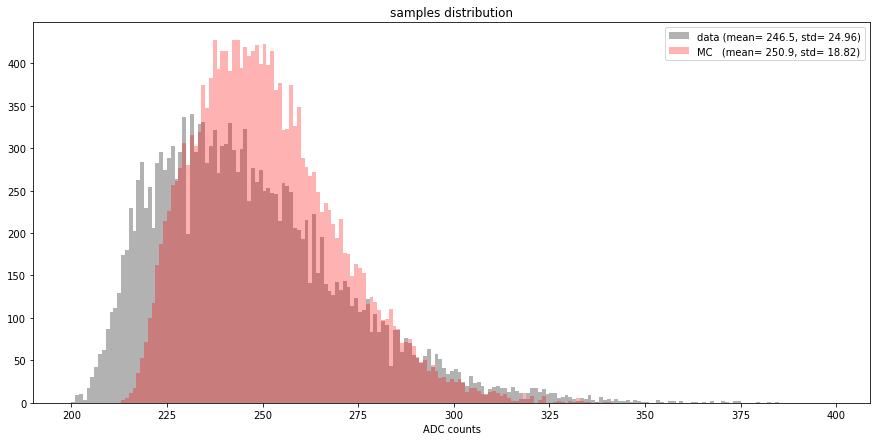

In [16]:
h1pix_data = wfs_data[:,3,:].flatten()
h1pix_MC   = wfs_MC[:,0,:].flatten()
n,b,p = plt.hist(h1pix_data,bins=np.arange(200,400,1),color='black', \
                 label='data (mean= {:.4}, std= {:.4})'.format(h1pix_data.mean(),h1pix_data.std()), alpha=.3)
n,b,p = plt.hist(h1pix_MC,bins=np.arange(200,400,1),color='red', \
                 label='MC   (mean= {:.4}, std= {:.4})'.format(h1pix_MC.mean(),  h1pix_MC.std()),   alpha=.3)
l = plt.legend()
l = plt.gca().set_xlabel("ADC counts")
t = plt.gca().set_title('samples distribution')

In [17]:
wfs_data.mean()

248.83665953908292

In [18]:
wfs_MC.mean()

249.96659723158132

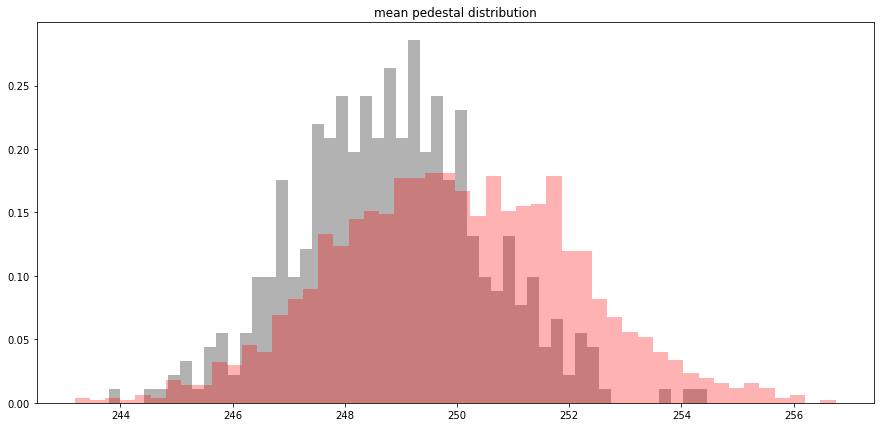

In [19]:
n,b,p = plt.hist(wfs_data.mean(axis=(0,2)),50,color='black', density=1, alpha=.3)
n,b,p = plt.hist(  wfs_MC.mean(axis=(0,2)),50,color='red',   density=1, alpha=.3)
t = plt.gca().set_title('mean pedestal distribution')

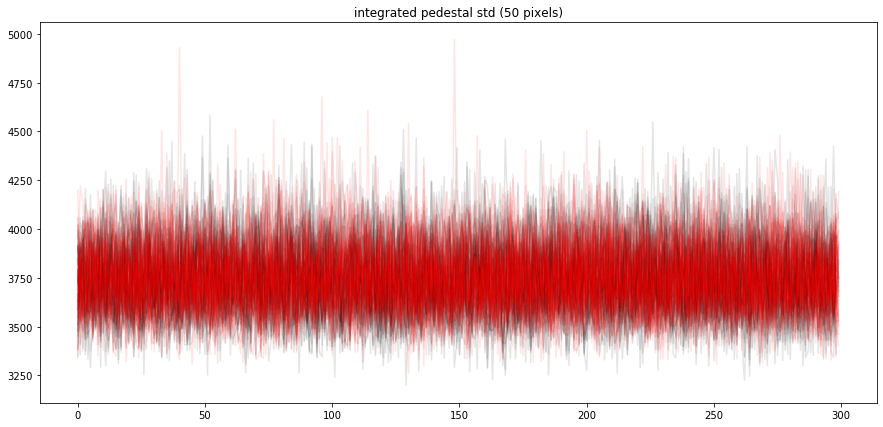

In [20]:
## integrated pedestal std

imin = 15
imax = 30
p = plt.plot(wfs_data[:,:50,imin:imax].sum(axis=2),color='black',alpha=.1)
p = plt.plot(wfs_MC[:,:50,imin:imax].sum(axis=2),color='red',alpha=.1)

t = plt.gca().set_title('integrated pedestal std (50 pixels)')

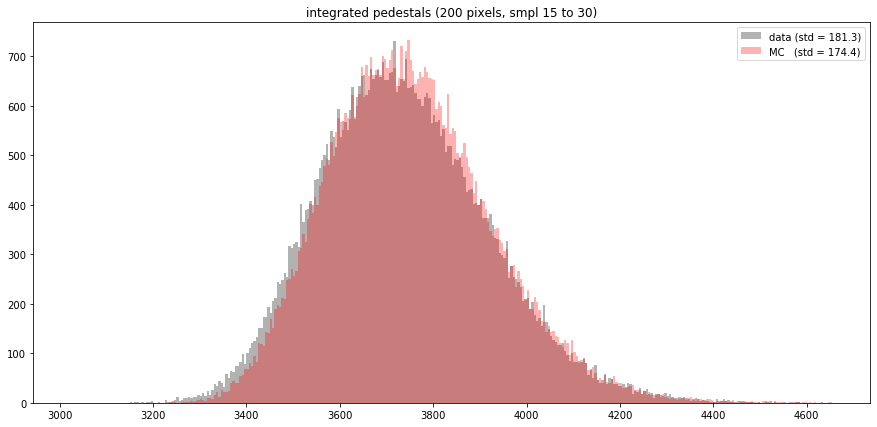

In [23]:
pixsmax = 200
p_std_data = wfs_data[:,:pixsmax,imin:imax].sum(axis=2).flatten().std()
p_std_MC = wfs_MC[:,:pixsmax,imin:imax].sum(axis=2).flatten().std()

hmin = round((imax-imin)*250-4*p_std_data)
hmax = round((imax-imin)*250+5*p_std_data)

p = plt.hist(wfs_data[:,:pixsmax,imin:imax].sum(axis=2).flatten(),\
             bins=np.arange(hmin,hmax,5), color='black', alpha=.3,\
             label='data (std = {:.4})'.format(p_std_data))

p = plt.hist(  wfs_MC[:,:pixsmax,imin:imax].sum(axis=2).flatten(),\
             bins=np.arange(hmin,hmax,5), color='red',   alpha=.3,\
             label='MC   (std = {:.4})'.format(p_std_MC))

l = plt.gca().set_title('integrated pedestals ({} pixels, smpl {} to {})'.format(pixsmax,imin,imax))
l = plt.gca().legend()


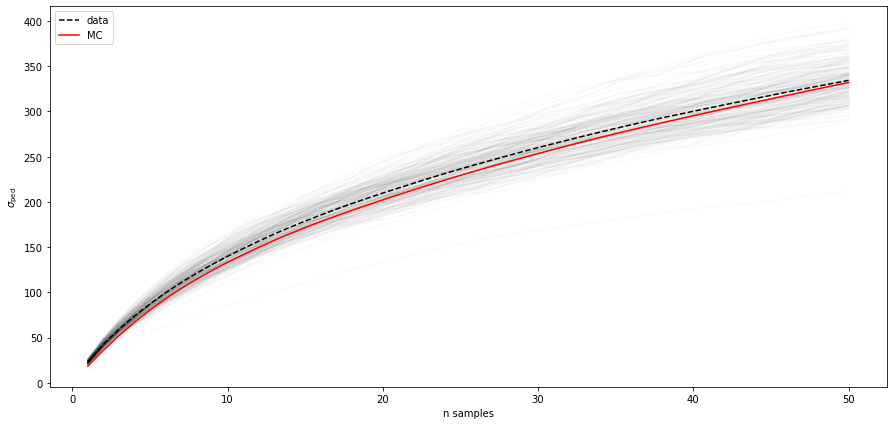

In [24]:
mnf = 50
data_nf = np.array([wfs_data[:,:pixsmax,10:11+ii].sum(axis=2) for ii in range(mnf)])
MC_nf   = np.array([  wfs_MC[:,:pixsmax,10:11+ii].sum(axis=2) for ii in range(mnf)])

#sdt_1spl    = wfs_data[:,:pixsmax,:].std(axis=(0,2)).mean()
#sdt_1spl_MC =   wfs_MC[:,:pixsmax,:].std(axis=(0,2)).mean()
#wfs_gauss = np.array([ np.array([np.random.normal(250,sdt_1spl_MC,60) for ii in range(200)] ) for wf in wfs_MC])
#gauss_nf  = np.array([  wfs_gauss[:,:pixsmax,10:11+ii].sum(axis=2) for ii in range(mnf)])
#plt.plot(range(50),data_nf.std(axis=1),color='black',alpha=.05)
#plt.plot(range(50),  MC_nf.std(axis=1),color='red',  alpha=.05)
smpl_array = np.arange(1,mnf+1,1)


plt.plot(smpl_array ,  data_nf.std(axis=1),'-', color='black',  alpha=.02)
plt.plot(smpl_array ,  data_nf.std(axis=1).mean(axis=1),'--', color='black',  alpha=1,label='data')
plt.plot(smpl_array ,  MC_nf.std(axis=1).mean(axis=1)       , color='red'  ,  alpha=1,label='MC')

#plt.plot(smpl_array ,  gauss_nf.std(axis=1).mean(axis=1)    , color='green',  alpha=1,label='gaussian')
#plt.plot(smpl_array ,  sdt_1spl_MC * smpl_array**.5, ':'    , color='blue' ,  alpha=1 , \
#         label = '$2.8 \sqrt{n_\mathrm{smpl}}$')
#plt.gca().set_yscale('log')
#plt.gca().set_xscale('log')

plt.gca().set_xlabel('n samples')
plt.gca().set_ylabel('$\sigma_\mathrm{ped}$')
l = plt.legend()

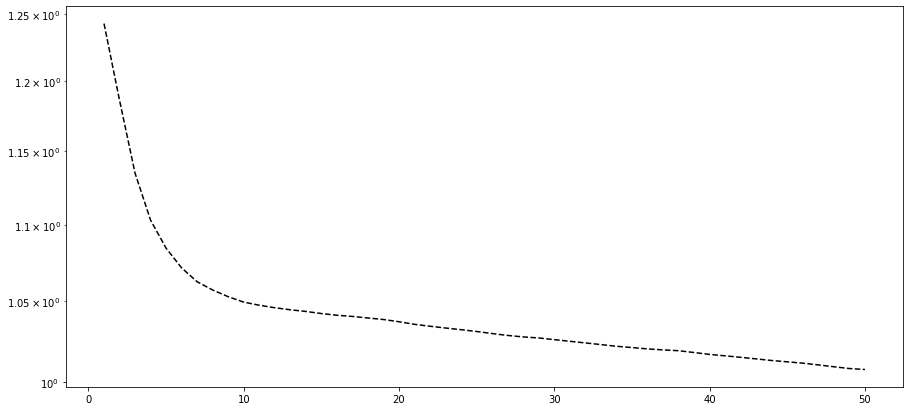

In [27]:
#plt.plot(smpl_array ,  data_nf.std(axis=1).mean(axis=1) ,'--', color='black',  alpha=1,label='data')
plt.plot(smpl_array ,  data_nf.std(axis=1).mean(axis=1)/MC_nf.std(axis=1).mean(axis=1),'--', color='black',  alpha=1,label='data')

plt.gca().set_yscale('log')
#plt.gca().set_xscale('log')

In [28]:
#n,b,p = plt.hist(np.max(wfs_data[:,0,:],axis=1),20,alpha=.4) 
#n,b,p = plt.hist(np.max(  wfs_MC[:,0,:],axis=1),20,alpha=.4)
#n,b,p = plt.hist(np.max(wfs_data[:,:pixsmax,:]- wfs_data[:,:pixsmax,:].mean(),axis=0).flatten()/14.,100, \
#                 color='black', alpha=.4) 
#n,b,p = plt.hist(np.max(  wfs_MC[:,:pixsmax,:]- wfs_MC[:,:pixsmax,:].mean(),axis=0).flatten()/14.,100, \
#                 color='red'  , alpha=.4)
#plt.gca().set_yscale('log')

In [29]:
        inputfile_reader = NectarCAMEventSource(
            input_url = data_file_path,
            max_events=2000)
        all_wfs = []
        for ii, event in enumerate(inputfile_reader):
            all_wfs.append(event.r0.tel[event.r0.tels_with_data[0]].waveform[0,pix_ids])
            
        all_wfs_data = np.array(all_wfs)

In [30]:

        #pp = poisson(.25)
        #rn_wfs_data  = all_wfs_data[:,:,:]- all_wfs_data[:,:,:].mean(axis=0)
        #rn_wfs_MC    = wfs_MC[:,:,:60]    -     wfs_MC[:,:,:60].mean(axis=0)
        #tt = pp.pmf( np.round((rn_wfs_data.max(axis=2)/14 ).flatten())) * len(rn_wfs_data.flatten())
        #tt2 = pp.pmf( np.round((rn_wfs_MC.max(axis=2)/14 ).flatten())) * len(rn_wfs_MC.flatten())
        
        #print(len(rn_wfs_data.flatten()))
        #logbins = np.logspace(-30,0,20)
        #n,b,p = plt.hist(tt,bins=logbins, \
        #         color='black', alpha=.4, label = 'data') 
        #n,b,p = plt.hist(tt2,bins=logbins, \
        #         color='red'  , alpha=.4,label = 'MC')
        
        #plt.gca().set_yscale('log')
        #plt.gca().set_xscale('log')
        #plt.gca().set_xlabel('Charge (p.e.)')
        #plt.gca().set_title('NSB+afterpulse specrum')
        #l=plt.gca().legend()

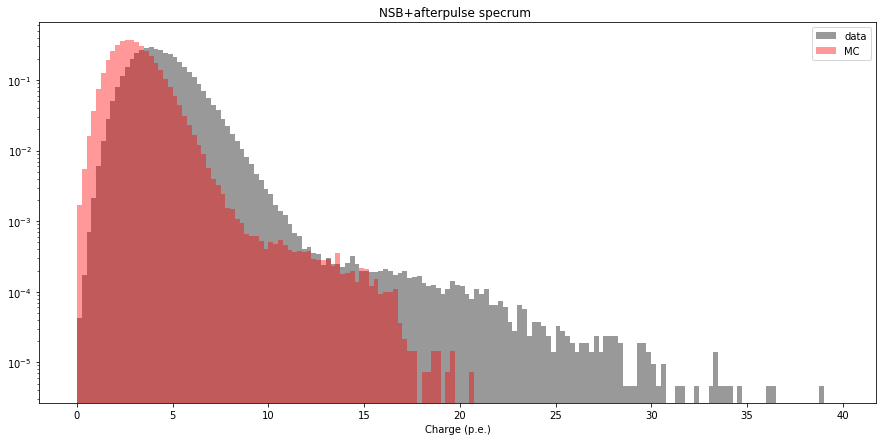

In [31]:

        
        rn_wfs_data  = all_wfs_data[:,:,:]- all_wfs_data[:,:,:].mean(axis=0)
        rn_wfs_MC    = wfs_MC[:,:,:60]    -     wfs_MC[:,:,:60].mean(axis=0)
        
        n,b,p = plt.hist((rn_wfs_data.max(axis=2)/14).flatten(),bins=np.arange(0,40,0.25), \
                 color='black', alpha=.4,density=1, label = 'data') 
        n,b,p = plt.hist((rn_wfs_MC.max(axis=2)/14).flatten(),bins=np.arange(0,40,0.25), \
                 color='red'  , alpha=.4,density=1, label = 'MC')
        
        plt.gca().set_yscale('log')
        plt.gca().set_xlabel('Charge (p.e.)')
        plt.gca().set_title('NSB+afterpulse specrum ')
        l=plt.gca().legend()

In [32]:
rn_wfs_data.min()
#np.where(rn_wfs_data==-251.076)
#np.where(all_wfs_data==0)

-92.358

In [18]:
#evtX = all_wfs_data[2170]
#aa = plt.plot(evtX.T,color="black",alpha=.05)

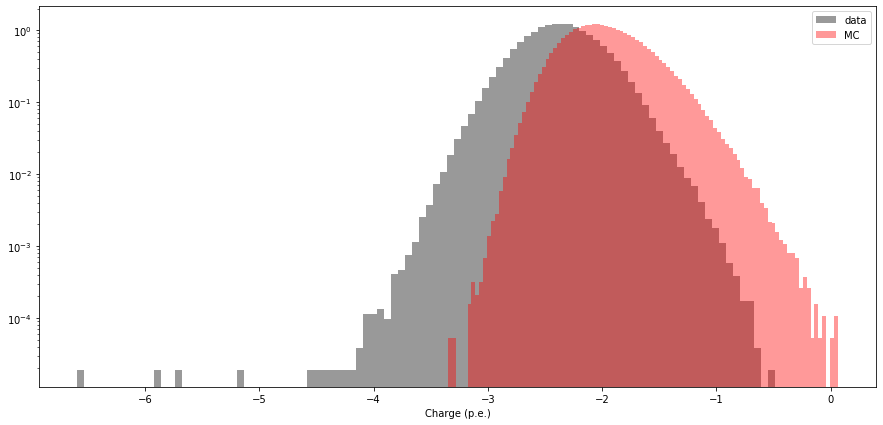

In [33]:
        n,b,p = plt.hist((rn_wfs_data.min(axis=2)/14).flatten(),100, \
                 color='black', alpha=.4,density=1, label = 'data') 
        n,b,p = plt.hist((rn_wfs_MC.min(axis=2)/14).flatten(),100, \
                 color='red'  , alpha=.4,density=1, label = 'MC')
        plt.gca().set_yscale('log')
        plt.gca().set_xlabel('Charge (p.e.)')
        l=plt.gca().legend()

In [35]:
rn_wfs_MC[:,:,:60].sum(axis=1).shape


(300, 60)

In [36]:
        MC_file_path0 ='/media/ttaverni/Transcend/MC_s/Heide/nsb0_thrs0_new_notes.simtel.gz'
        inputfile_reader = event_source(
            input_url = MC_file_path0,
            max_events=500)

        all_wfs = []
        for ii, event in enumerate(inputfile_reader):
            all_wfs.append(event.r0.tel[1].waveform[0])
        wfs_MC0 = np.array(all_wfs)

In [37]:
        ## NSB = 0 : 
        data_file_path0 = '/media/ttaverni/Transcend/data/dataR1/NectarCAM.Run1533.0000.fits.fz'
        
        inputfile_reader = NectarCAMEventSource(
            input_url = data_file_path0,
            max_events=5000)

        cfg = inputfile_reader.camera_config
        pix_ids = cfg.expected_pixels_id
        
        all_wfs = []
        for ii, event in enumerate(inputfile_reader):
            all_wfs.append(event.r0.tel[event.r0.tels_with_data[0]].waveform[0,pix_ids])
            if ii > len(wfs_MC)-3 : 
                break
        wfs_data0 = np.array(all_wfs)

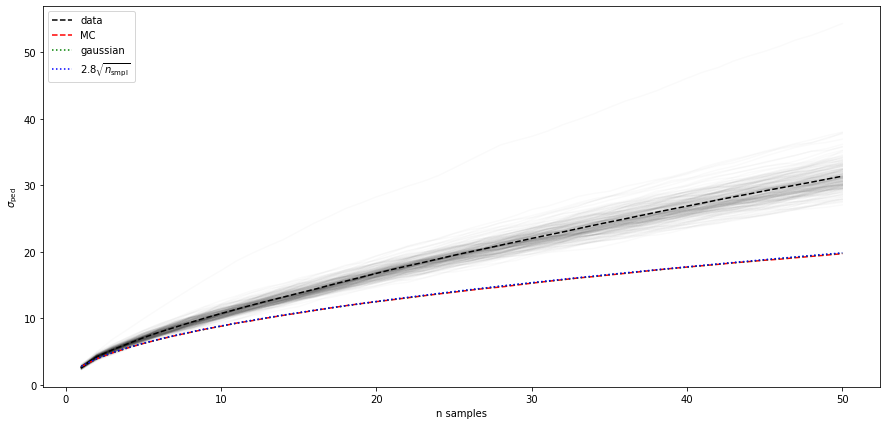

In [38]:
mnf = 50
data_nf = np.array([wfs_data0[:,:pixsmax,10:11+ii].sum(axis=2) for ii in range(mnf)])
MC_nf   = np.array([  wfs_MC0[:,:pixsmax,10:11+ii].sum(axis=2) for ii in range(mnf)])

sdt_1spl    = wfs_data0[:,:pixsmax,:].std(axis=(0,2)).mean()
sdt_1spl_MC =   wfs_MC0[:,:pixsmax,:].std(axis=(0,2)).mean()

wfs_gauss = np.array([ np.array([np.random.normal(250,sdt_1spl_MC,60) for ii in range(200)] ) for wf in wfs_MC])
gauss_nf  = np.array([  wfs_gauss[:,:pixsmax,10:11+ii].sum(axis=2) for ii in range(mnf)])

#plt.plot(range(50),data_nf.std(axis=1),color='black',alpha=.05)
#plt.plot(range(50),  MC_nf.std(axis=1),color='red',  alpha=.05)
smpl_array = np.arange(1,mnf+1,1)

plt.plot(smpl_array ,  data_nf.std(axis=1)              , '-', color='black',  alpha=.02)
plt.plot(smpl_array ,  data_nf.std(axis=1).mean(axis=1) ,'--', color='black',  alpha=1, label='data')
plt.plot(smpl_array ,  MC_nf.std(axis=1).mean(axis=1)   ,'--', color='red'  ,  alpha=1, label='MC')
plt.plot(smpl_array ,  gauss_nf.std(axis=1).mean(axis=1), ':', color='green',  alpha=1, label='gaussian')
plt.plot(smpl_array ,  sdt_1spl_MC * smpl_array**.5     , ':', color='blue' ,  alpha=1 , \
         label = '$2.8 \sqrt{n_\mathrm{smpl}}$')

#plt.plot(smpl_array ,  sdt_1spl * smpl_array**.5, '-.'    , color='blue' ,  alpha=1 , \
#         label = '$15.8 \sqrt{n_\mathrm{smpl}}$')
plt.gca().set_xlabel('n samples')
plt.gca().set_ylabel('$\sigma_\mathrm{ped}$')
l = plt.legend()